<a href="https://colab.research.google.com/github/PersiaKamali/MachineLearningProject/blob/main/Machine_Learning_project_Persia_Kamali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Project:  Unsupervised and supervised analysis of protein sequences**



In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as npì
import random
from datetime import datetime

aminoacids = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [ ]:
#Setting parameters for plots
plt.rcParams["figure.figsize"] = (15,10)
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.rc('legend', fontsize = 'medium') # using a named size

# **TASK 1: One-hot encoding of protein sequence data**

The data are multiple-sequence alignments (MSA) of protein sequences. Each sequence is made of 96 characters, which may take values from the 20 natural amino acids {A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y} or the alignment gap ‘-‘.

Since many ML models require a numerical input, we performed one-hot encoding on both the natural and the artificial sequences: we transformed each sequence into a multi-dimensional vector, where each amino acid was identified by a 20-dimensional vector with all entries equal to 0 except one equal to 1. This changed the number of features from 96 to 2920.

We also performed an integer encoding, which will be useful for point 5.


In [ ]:
def upload_data(pathfile):

  with open (pathfile, "r") as myfile:
      data=myfile.readlines()

  data_points = []
  y_labels = []

  for i in range(0, len(data), 4):

    y_labels.append(1 if 'true' in data[i] else 0)
    new = data[i+1] + data[i+2]
    new1 = new.replace('\n', '')
    data_points.append(new1)

  return data_points, np.array(y_labels)

def one_hot_enc(data):

    seq_tensor = np.zeros((len(data), len(data[0])*(len(aminoacids)-1)), dtype=np.float16)
    ie_tensor = np.zeros((len(data), len(data[0])), dtype=np.float16)

    for line in data:

        n = data.index(line)

        for i in range(len(line)):
            char = line[i]
            if char in aminoacids and char != '-':
                seq_tensor[n, i*20+(aminoacids.index(char)-1)] = 1
                ie_tensor[n, i] = aminoacids.index(char)
            if i == len(line) - 1:
                break

    return seq_tensor, ie_tensor

In [ ]:
data, y = upload_data("/content/MSA_nat_with_annotation.faa")
X, X_ie = one_hot_enc(data)

data_G, y_G = upload_data("/content/MSA_art.faa")
XG, X_Gie = one_hot_enc(data_G)

# **TASK 2: Dimensional reduction and visualization of sequence space**

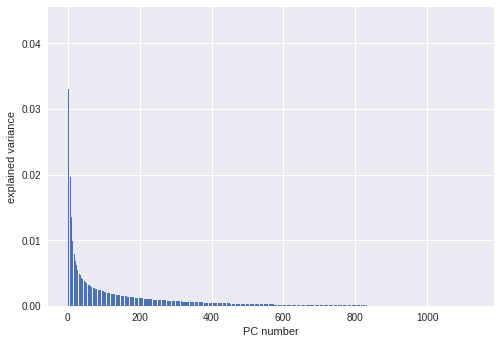

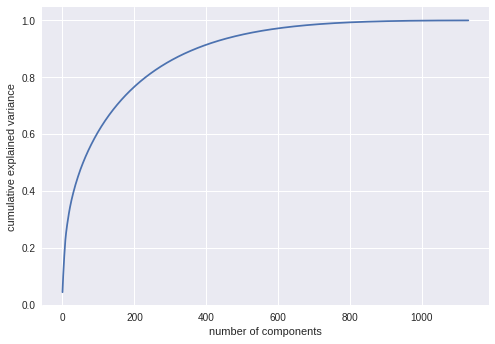

In [ ]:
#PCA Analysis
from sklearn.decomposition import PCA

plt.style.use('seaborn')

pca = PCA().fit(X)

variances=pca.explained_variance_ratio_
plt.bar(range(1,len(variances)+1),variances )
plt.xlabel('PC number')
plt.ylabel('explained variance');
plt.show()

plt.plot(np.cumsum(pca.explained_variance_ratio_))  #cumulative sum
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

Here we have plotted the explained variance and the cumulant explained variance in function of the number of components in order to see how many components is important to mantain.

[0.04337461 0.03301329]


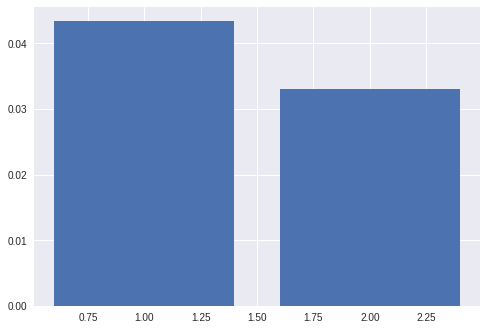

In [ ]:
pca = PCA(n_components=2)
Xproj = pca.fit_transform(X)
variances=pca.explained_variance_ratio_

plt.bar([1,2],variances)
print(variances)

In [ ]:
pca = PCA().fit(X)

variances=pca.explained_variance_ratio_
x = np.arange(len(np.cumsum(pca.explained_variance_ratio_)))
x[np.cumsum(pca.explained_variance_ratio_) >= 0.90][0]

370

By performing PCA analysis on the dataset of the natural sequences, we observe that a two-dimensional projection loses a lot of information (as measured by the explained variance) and that we would need at least 370 components to retain 90% of the variance. With only two components we retained about 7.6% of the variance, which is very low. Thus, we expect the PCA analysis not to be very informative but still useful for data visualisation.

## Visualising sequences in 2D PCA space

Here we are plotting the natural sequences.

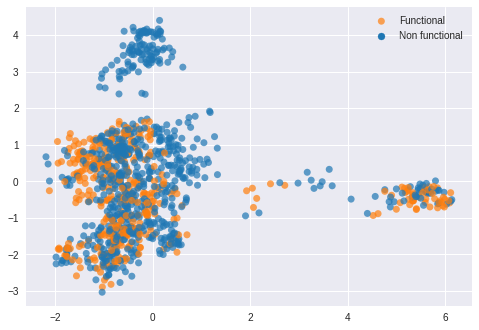

In [ ]:
pca = PCA()
Xproj = pca.fit_transform(X)
sns.scatterplot(x=Xproj[:, 0], y=Xproj[:, 1], hue=y, edgecolor='none', alpha = 0.7, palette="tab10")
plt.legend(['Functional','Non functional'])
plt.show()

Here we have plotted the first two principal components of the natural sequences. The blue dots are non-functional sequences, while the orange dots are functional sequences of proteins.
One can easily observe that both of the types of sequences live in the same region of space, thus they are not well-separated.
The only exception are two small clusters of non-functional sequences: one in the top-left region and one in the center region.

In the following, a plot of both the artifical sequences and the natural sequences.

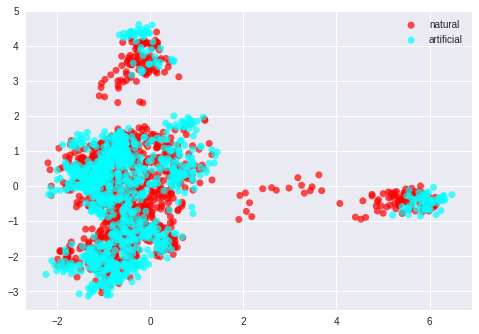

In [ ]:
XprojG = pca.transform(XG)

plt.scatter(Xproj[:, 0], Xproj[:,1], label='natural', color= 'red', edgecolor='none', alpha=0.7)
plt.scatter(XprojG[:, 0], XprojG[:,1], label='artificial', color= 'cyan', edgecolor='none', alpha=0.7)
plt.legend()

The artificial sequences occupy a similar region of the natural sequences, making them almost indistinguishable in PCA space. Although, one can observe that there are no artificial sequences in center region, between x-coordinates 2 and 4.

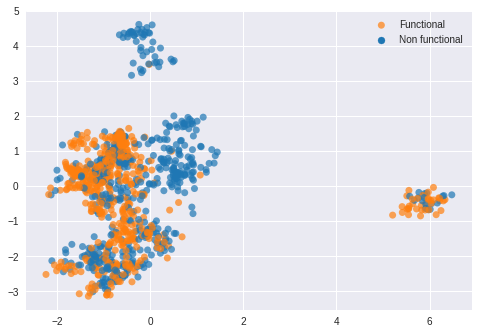

In [ ]:
XprojG = pca.transform(XG)

sns.scatterplot(x=XprojG[:, 0], y=XprojG[:, 1], hue=y_G, edgecolor='none', alpha=0.7, palette="tab10")
plt.legend(['Functional','Non functional'])
plt.show()

As in the case of the natural sequences, functional and non-functional artificial sequences occupy the same region of space. Also in this case, we can distinguish two clusters made of mainly non-functional sequences, the same as in the natural case (even though in this case there are some natural sequences).

# **TASK 3: Clustering sequence data**

## Clustering with K-Means

### Clustering natural sequences
First we perform a clustering algorithm on the natural sequence. Ideally, we would like to be able to distinguish clusters of functional and non-functional sequences.

(10, 1920)

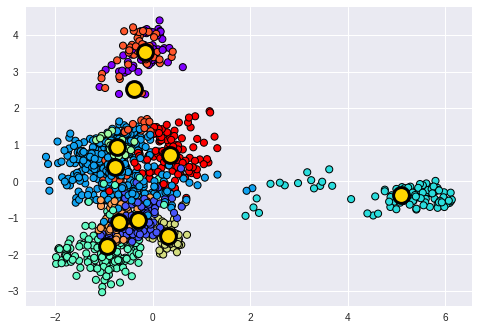

In [ ]:
from sklearn.cluster import KMeans

est = KMeans(10)
est.fit(X)
pc_clusters =  pca.transform(est.cluster_centers_)
y_kmeans = est.predict(X)
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y_kmeans, s=50, cmap='rainbow',edgecolor='black', linewidth=1)
plt.scatter(pc_clusters[:,0], pc_clusters[:,1], s=250, color="gold", edgecolor='black', linewidth=3)
est.cluster_centers_.shape

In [ ]:
X.shape[0]/2

565.0

A preliminary clustering with 10 clusters shows that the algorithm is able to group only some similar sequences toghether. Further analysis is needed.
In order to choose the best number of clusters, we can split the data set in two and see what is the maximum number of clusters for which the two clustering algorithms agree.

In [ ]:
def try_N_clusters(N):
  model_1 = KMeans(N)  # N clusters
  model_1.fit(X[0:565,:])
  y_model_1 = model_1.predict(X)
  model_2 = KMeans(N)  # N clusters
  model_2.fit(X[565:,:])
  y_model_2 = model_2.predict(X)

  fig, ax = plt.subplots(1, 2, figsize=(20, 10))
  ax[0].scatter(Xproj[:, 0], Xproj[:, 1], c=y_model_1, s=50, cmap='rainbow')
  ax[0].set_title('clusters learned on first half')

  ax[1].scatter(Xproj[:, 0], Xproj[:, 1], c=y_model_2, s=50, cmap='rainbow')
  ax[1].set_title('clusters learned on second half');


from ipywidgets import interact
interact(try_N_clusters, N=(1, 20));

As one can easily observe, there is no cluster number for which the two algorithms can agree on. We can although analyse further and compare the clustering with the original labels.

In [ ]:
def try_N_clusters2(N):
  est = KMeans(N)
  est.fit(X)
  y_kmeans = est.predict(X)

  fig, ax = plt.subplots(1, 2, figsize=(20, 10))
  ax[0].scatter(Xproj[:, 0], Xproj[:, 1], c=y, s=50, cmap='rainbow')
  ax[0].set_title('True labels')

  ax[1].scatter(Xproj[:, 0], Xproj[:, 1], c=y_kmeans, s=50, cmap='rainbow')
  ax[1].set_title('Clustering with K-means');

from ipywidgets import interact
interact(try_N_clusters2, N=(1, 20));

interactive(children=(IntSlider(value=10, description='N', max=20, min=1), Output()), _dom_classes=('widget-in…

Note that purple dots are the non-functional sequences while the red dots are the functional sequences.
Starting from three clusters, the K-means algorithm distinguishes the top-left cluster made of only non-functional sequences but there is no number of clustering that is able to distinguish two clusters in the blob at the right.

We conclude that the clustering algorithm is not useful in distinguishing between functional and non-functional sequences.

### Clustering of both natural and artificial sequences
Here we perform a clustering algorithm on both natural and artificial sequence.

In [ ]:
#Test K-means on the whole dataset
XC = np.vstack((X,XG))

z = len(y) + len(y_G)
yC= np.zeros(z)
for i in range(z):
  if i<len(y):
    yC[i] = 0
  else:
    yC[i] = 1

In [ ]:
XprojC = pca.transform(XC)

In [ ]:
def try_N_clusters3(N):
  est2 = KMeans(N)
  est2.fit(XC)
  y_kmean2 = est2.predict(XC)

  fig, ax = plt.subplots(1, 2, figsize=(20, 10))
  ax[0].scatter(XprojC[:, 0], XprojC[:, 1], c=y_kmean2, cmap='rainbow')
  ax[0].set_title('learned cluster labels')

  ax[1].scatter(XprojC[:, 0], XprojC[:, 1], c=yC, cmap='rainbow')
  ax[1].set_title('true labels');

interact(try_N_clusters3, N=(1, 40));

Note that red dots are the artifical sequences while the purple dots are the natural sequences. Even in this case, there is no optimal number of cluster that is able to group the same sequences toghether.

## Clustering with DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
def DBSC(ep, N):

  model = DBSCAN(eps=ep, min_samples=N)
  ydb = model.fit_predict(X)

  fig, ax = plt.subplots(1, 2, figsize=(20, 10))
  ax[0].scatter(Xproj[:, 0], Xproj[:, 1], c=ydb, s=50, cmap='rainbow')
  ax[0].set_title('Clustering with DBSCAN')

  ax[1].scatter(Xproj[:, 0], Xproj[:, 1], c=y, s=50, cmap='rainbow')
  ax[1].set_title('True labels');


from ipywidgets import interact
interact(DBSC, ep=(0.001, 1, 0.01), N=(1, 40))

interactive(children=(FloatSlider(value=0.491, description='ep', max=1.0, min=0.001, step=0.01), IntSlider(val…

<function __main__.DBSC(ep, N)>

## Agglomerative clustering


In [ ]:
from sklearn.cluster import AgglomerativeClustering
def AGG(N):

  model = AgglomerativeClustering(n_clusters=N)
  yagc = model.fit_predict(X)

  fig, ax = plt.subplots(1, 2, figsize=(20, 10))
  ax[0].scatter(Xproj[:, 0], Xproj[:, 1], c=yagc, s=50, cmap='rainbow')
  ax[0].set_title('Agglomerative clustering')

  ax[1].scatter(Xproj[:, 0], Xproj[:, 1], c=y, s=50, cmap='rainbow')
  ax[1].set_title('True labels');

interact(AGG, N=(1, 40))

interactive(children=(IntSlider(value=20, description='N', max=40, min=1), Output()), _dom_classes=('widget-in…

<function __main__.AGG(N)>

In [ ]:
#Comparision between agglomerative and kmeans
from sklearn.cluster import AgglomerativeClustering
def AGG_vs_K(N):

  model1 = AgglomerativeClustering(n_clusters=N)
  y1 = model1.fit_predict(X)

  model2 = KMeans(N)
  y2 = model2.fit_predict(X)

  fig, ax = plt.subplots(1, 2, figsize=(20, 10))
  ax[0].scatter(Xproj[:, 0], Xproj[:, 1], c=y1, s=50, cmap='rainbow')
  ax[0].set_title('Agglomerative clustering')

  ax[1].scatter(Xproj[:, 0], Xproj[:, 1], c=y2, s=50, cmap='rainbow')
  ax[1].set_title('K-means');

interact(AGG_vs_K, N=(1, 40))

interactive(children=(IntSlider(value=20, description='N', max=40, min=1), Output()), _dom_classes=('widget-in…

<function __main__.AGG_vs_K(N)>

### Clustering both natural and artificial sequences


In [ ]:
def AGG2(N):

  model = AgglomerativeClustering(n_clusters=N)
  yagc = model.fit_predict(XC)

  fig, ax = plt.subplots(1, 2, figsize=(20, 10))
  ax[0].scatter(XprojC[:, 0], XprojC[:, 1], c=yagc, s=50, cmap='rainbow')
  ax[0].set_title('Agglomerative clustering')

  ax[1].scatter(XprojC[:, 0], XprojC[:, 1], c=yC, s=50, cmap='rainbow')
  ax[1].set_title('True labels');

interact(AGG2, N=(1, 100));

interactive(children=(IntSlider(value=50, description='N', min=1), Output()), _dom_classes=('widget-interact',…

# **TASK 4: Predicting protein functionality**

The goal of this section is to check if a classifier like the logistic regression is able to learn functional and non-functional sequences and distinguish between natural and artificial sequences.


## Logistic Regression for natural sequences
In this section, we test if the logistic regression is able to predict well the functionality of the natural sequences.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Splitting dataset between Xtrain, Xvalid and Xtest
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1)
X_test, X_valid, y_test, y_valid= train_test_split(X_temp, y_temp, test_size=0.5,random_state=1)

print(X_train.shape[0])
print(X_valid.shape[0])
print(X_test.shape[0])

791
170
169


Here we test the logistic regression on the validation set.

[[89 11]
 [22 48]]


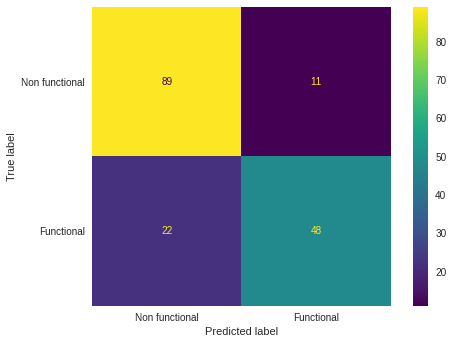

0.8058823529411765

In [ ]:
model_c=LogisticRegression(max_iter=200)
model_c.fit(X_train, y_train)
y_pred = model_c.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
prob=model_c.predict_proba(X_valid)

print(cm)

disp=ConfusionMatrixDisplay(cm, display_labels=['Non functional', 'Functional'])
disp.plot()
plt.grid(False)
plt.show()
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

model_c.score(X_valid, y_valid)

According to an initial logistic regression, there are 59 functional sequences in the natural set, which in reality are 70. The number of errors made is 33 and the accuracy is then 81%. We can check if this can be improved by changing the threshold.

In [ ]:
total_error = np.zeros(0)
false_functional = np.zeros(0)
threshold=np.linspace(0.01,0.5,10000)
y_treshold=np.zeros(X_valid.shape[0])

for thr in threshold:
  y_treshold=np.zeros(X_valid.shape[0])
  for i in range(len(y_treshold)):
    if prob[i,1]>=thr: #probability that sample i is functional > threshold
      y_treshold[i]=1
    else:
      y_treshold[i]=0
  cm = confusion_matrix(y_valid, y_treshold)
  total_error = np.append(total_error, cm[0,1]+cm[1,0])
  false_functional = np.append(false_functional, cm[0,1])

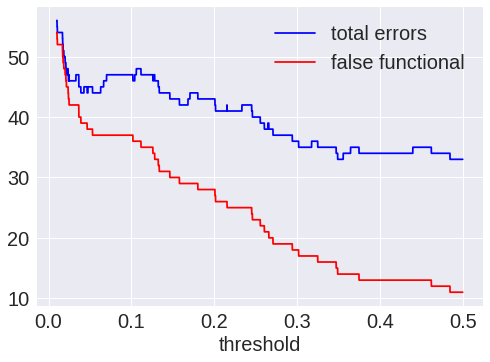

In [ ]:
plt.plot(threshold, total_error, c='blue', label='total errors')
plt.plot(threshold, false_functional, c='red',label='false functional')
plt.xlabel('threshold', fontsize=20)
plt.legend(loc="upper right", fontsize=20)

  Thus, the minimum number of errors is made if we keep the threshold at 0.5. We can proceed by performing the logistic regression on the test set, keeping the threshold at 0.5.

[[86 15]
 [26 42]]


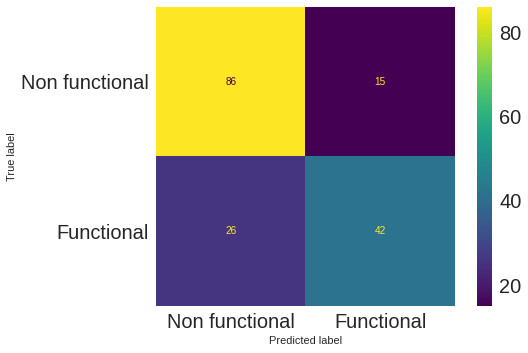

0.757396449704142

In [ ]:
model_c=LogisticRegression(max_iter=200)
model_c.fit(X_train, y_train)
y_pred = model_c.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(cm)

disp=ConfusionMatrixDisplay(cm, display_labels=['Non functional', 'Functional'])
disp.plot()
plt.rcParams.update({'font.size': 40})
plt.grid(False)
plt.show()

model_c.score(X_test, y_test)

We also perform a logistic regression on the training set.

[[506   0]
 [  0 285]]


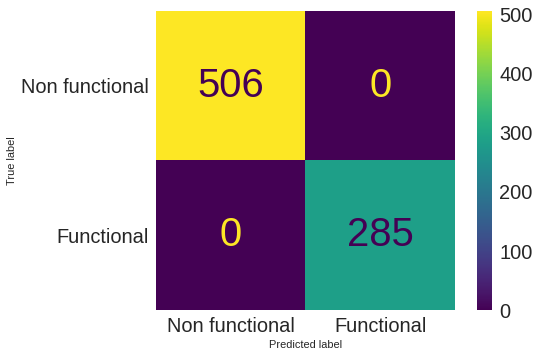

1.0

In [ ]:
model_c=LogisticRegression(max_iter=200)
model_c.fit(X_train, y_train)
y_pred = model_c.predict(X_train)
cm = confusion_matrix(y_train, y_pred)

print(cm)

disp=ConfusionMatrixDisplay(cm, display_labels=['Non functional', 'Functional'])
disp.plot()
plt.rcParams.update({'font.size': 40})
plt.grid(False)
plt.show()

model_c.score(X_train, y_train)

As expected, the accuracy score is 100%.

## Logistic Regression for artificial sequences
In this section, we test if the logistic regression is able to predict well the functionality of the artificial sequences.

[[413  91]
 [137 362]]


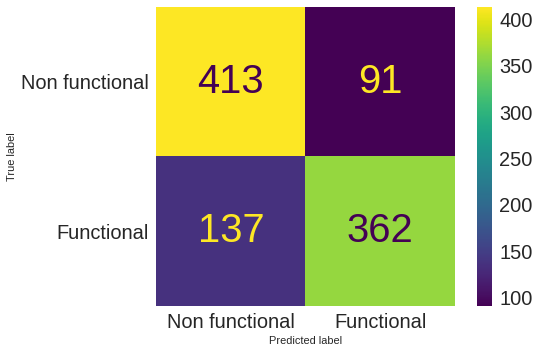

0.7726819541375872

In [ ]:
model_c=LogisticRegression(max_iter=200)
model_c.fit(X_train, y_train)
y_pred = model_c.predict(XG)
cm = confusion_matrix(y_G, y_pred)
prob=model_c.predict_proba(XG)

print(cm)

disp=ConfusionMatrixDisplay(cm, display_labels=['Non functional', 'Functional'] )
disp.plot()
plt.rcParams.update({'font.size': 40})
plt.grid(False)
plt.show()

model_c.score(XG, y_G)

The number of errors made is equal to 228 and the accuracy score is about 77%.

## Logistic regression for artificial and natural sequences
In this section, we check if the logistic regression can distinguish between natural and artificial sequences.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Splitting dataset between Xtrain, Xvalid and Xtest
X_train2, X_temp2, y_train2, y_temp2 = train_test_split(XC, yC, test_size=0.3, random_state=1)
X_test2, X_valid2, y_test2, y_valid2= train_test_split(X_temp, y_temp, test_size=0.5,random_state=1)

print(X_train2.shape[0])
print(X_valid2.shape[0])
print(X_test2.shape[0])

1493
170
169


[[88 12]
 [60 10]]


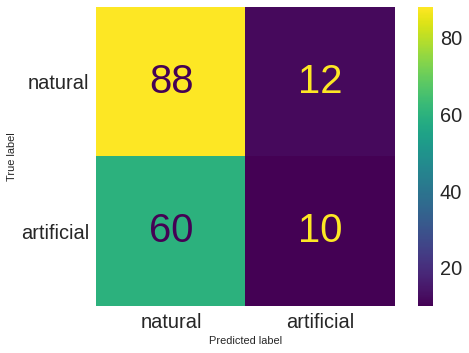

0.5764705882352941

In [ ]:
model_c=LogisticRegression(max_iter=200)
model_c.fit(X_train2, y_train2)
y_pred2 = model_c.predict(X_valid2)
cm = confusion_matrix(y_valid2, y_pred2)


print(cm)

disp=ConfusionMatrixDisplay(cm, display_labels=['natural', 'artificial'])
disp.plot()
plt.rcParams.update({'font.size': 40})
plt.grid(False)
plt.show()

model_c.score(X_valid2, y_valid2)

# **TASK 5: Generating artificial sequences**
In the following, we will learn a generative model from the set of natural sequences and perform a sampling of the learnt probability distribution. In order to asses if the sampled sequences are any good, we will use the results from the previous tasks. The sampled sequences will be considered good if:


*   They live in the same space as the natural sequences.
*   They are not distinguishable from the natural sequences geometrically. We'll assess this through the clustering algorithms.


*   They are not distinguishable by a hard classfier.

We will also check if they are considered functional or non functional sequences.

## Pseudolikelihood maximisation and Gibbs sampling

In [ ]:
#Importing necessary libraries
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from random import choices
import time


#Perform Pseudolikelihood maximisation: perform 96 Logistic Regresssion, one for each site
#A=training set, niter = number of iterations for the Logistic Regression
def PSL(A, niter):

  for i in range(A.shape[1]):

    pkl_filename = "LR_%i" %i
    selector = []
    selector = [x for x in range(A.shape[1]) if x != i]

    model=LogisticRegression(max_iter = niter)
    model.fit(A[:, selector], A[:, i])

    with open(pkl_filename, 'wb') as file:
      pickle.dump(model, file)


#Perform sampling: take each sequence from A and sample 'nsamples' sequences. Sampling from original sequence starts after
#'niter1' iterations.
def sampling(A, nsamples, niter):

  m = 0 #counter for samples
  n = 0 #counter for iterations
  gen_sequences = np.zeros((nsamples, A.shape[1]), dtype=np.float16) #initialising the output

  S = np.random.randint(0, 21, A.shape[1]) #random initial condition

  #Preparing file
  timestr = time.strftime("%Y%m%d-%H%M%S")
  myFileName = "generated_sequences_" + timestr + ".yml"
  with open(myFileName, 'a+', newline='') as outfile:
    outfile.write('Number of sequence sampled ' + str(nsamples) + '\n')
    outfile.write('Sampling begins after ' + str(niter) + ' iterations')
    outfile.write('\n')

  #Performing Gibbs sampling
  while m != nsamples:

    for i in range(96):

      selector = []
      selector = [x for x in range(A.shape[1]) if x != i]
      pkl_filename = "LR_%i" %i

      with open(pkl_filename, 'rb') as file:
        model = pickle.load(file)

      proba = model.predict_proba(S[selector].reshape(1, 95))
      proba = np.squeeze(np.asarray(proba))

      if proba.shape[0] != 21:

        l = 0
        missing_amm = [item for item in np.arange(0,21) if item not in A[:,i]]
        new_prob = np.zeros(21)

        for k in range(21):
          if k in missing_amm:
            new_prob[k] = 0
          else:
            new_prob[k] = proba[l]
            l += 1

        proba = new_prob

      amm = np.random.choice(np.arange(0, 21), p=proba)
      S[i] = amm

    if (n >= niter and n%niter == 0):
      gen_sequences[m] = S
      m += 1

      with open(myFileName, 'a+', newline='') as outfile:
        S_list = S.tolist()
        outfile.write(str(S_list) + '\n')

    if (m%1000 == 0 and m != 0):
      print("Number of sequences sampled so far: " + str(m))

    n += 1

  return gen_sequences

#Function for transforming integer embeding to one hot embeding
def ie_to_ohe(data):

  n = len(data)
  oh_data = np.zeros((n,96,20))

  for j in range(len(data)):
    for i in range(len(data[0])):
      if data[j][i] == 0: continue
      if data[j][i] == 1: oh_data[j][i][0] = 1;
      if data[j][i] == 2: oh_data[j][i][1] = 1;
      if data[j][i] == 3: oh_data[j][i][2] = 1;
      if data[j][i] == 4: oh_data[j][i][3] = 1;
      if data[j][i] == 5: oh_data[j][i][4] = 1;
      if data[j][i] == 6: oh_data[j][i][5] = 1;
      if data[j][i] == 7: oh_data[j][i][6] = 1;
      if data[j][i] == 8: oh_data[j][i][7] = 1;
      if data[j][i] == 9: oh_data[j][i][8] = 1;
      if data[j][i] == 10: oh_data[j][i][9] = 1;
      if data[j][i] == 11: oh_data[j][i][10] = 1;
      if data[j][i] == 12: oh_data[j][i][11] = 1;
      if data[j][i] == 13: oh_data[j][i][12] = 1;
      if data[j][i] == 14: oh_data[j][i][13] = 1;
      if data[j][i] == 15: oh_data[j][i][14] = 1;
      if data[j][i] == 16: oh_data[j][i][15] = 1;
      if data[j][i] == 17: oh_data[j][i][16] = 1;
      if data[j][i] == 18: oh_data[j][i][17] = 1;
      if data[j][i] == 19: oh_data[j][i][18] = 1;
      if data[j][i] == 20: oh_data[j][i][19] = 1;

  oh_data = oh_data.reshape((n, 1920))
  return oh_data

#Function for uploading the sampled sequences from the file
def upload_data2(pathfile):

  with open (pathfile, "r") as myfile:
    data=myfile.readlines()

  data_points = []

  for i in range(0, len(data)):
    new = data[i]
    new1 = new.replace('\n', '')
    new2 = new1.replace(',', ' ')
    data_points.append(new2)

  input_data = np.array([list(map(int, line.split( ))) for line in data_points])

  return input_data.reshape((len(data), 96))

In [ ]:
#Perform learning of logistic regressions, ie pseudolikelihood maximisation
PSL(X_ie, 200)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

KeyboardInterrupt: ignored

In [ ]:
generated_sequences = sampling(X_ie, 800, 1000)

FileNotFoundError: ignored

In [ ]:
print(generated_sequences)

In [ ]:
 #Uploading sampled sequences
data = upload_data2('/content/gen_sequences_28.01.23.txt')

In [ ]:
print(data)

[[ 1 13 16 ... 12  4  0]
 [18 14  3 ... 12  3 19]
 [12 11 18 ...  3 15 17]
 ...
 [ 9  1  1 ... 16 12 12]
 [ 0  0  0 ... 18 15  6]
 [ 6 15  4 ...  4  9 18]]


In [ ]:
#Transforming data for integer encoding to one hot encoding
Z = ie_to_ohe(data)

## PCA of the sampled sequences

In [ ]:
#Project sampled sequences in the natural sequences space
pca = PCA().fit(X)
Xproj = pca.fit_transform(X)
Zproj = pca.transform(Z)

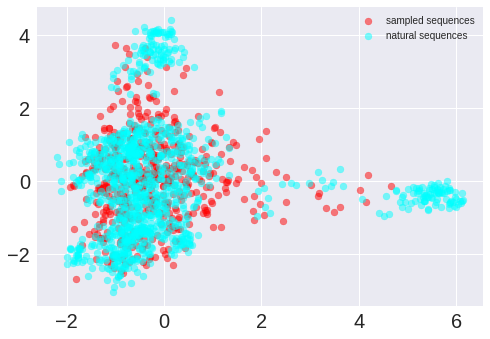

In [ ]:
#Plot the sampled and natural sequences
plt.scatter(Zproj[:, 0], Zproj[:,1], label='sampled sequences', color = 'red', alpha=0.5)
plt.scatter(Xproj[:, 0], Xproj[:,1], label='natural sequences', color = 'cyan', alpha=0.5)
plt.legend()
plt.show()

## Clustering of sampled sequences with K-means

In [ ]:
D = np.vstack((X, Z))
ynat = np.ones(X.shape[0])
ysam = np.zeros(Z.shape[0])
y = np.concatenate((ynat, ysam))

Dproj = pca.transform(D)

In [ ]:
def try_N_clusters(N):
  est = KMeans(N)
  est.fit(D)
  y_kmeans = est.predict(D)

  fig, ax = plt.subplots(1, 2, figsize=(20, 10))
  ax[0].scatter(Dproj[:, 0], Dproj[:, 1], c=y, s=50, cmap='rainbow')
  ax[0].set_title('True labels')

  ax[1].scatter(Dproj[:, 0], Dproj[:, 1], c=y_kmeans, s=50, cmap='rainbow')
  ax[1].set_title('Clustering with K-means');

from ipywidgets import interact
interact(try_N_clusters, N=(1, 20));

interactive(children=(IntSlider(value=10, description='N', max=20, min=1), Output()), _dom_classes=('widget-in…

Note that red dots are the natural sequences, while the purple dots are the sampled sequences.

## Logistic regression
Predicting if samples are functional or not functional sequences.

In [ ]:
#Learn logistic regression on the natural sequences
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1)
X_test, X_valid, y_test, y_valid= train_test_split(X_temp, y_temp, test_size=0.5,random_state=1)
model_s=LogisticRegression(max_iter=200)
model_s.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [ ]:
#apply logistic regression on sampled sequences
sam_seq_pred = model_s.predict(Z)

In [ ]:
#Separate functional and non functional sequences

Z_fun = Zproj[sam_seq_pred == True] #sampled seq that are functional
Z_nofun = Zproj[sam_seq_pred == False]

X_proj_fun = Xproj[ y == True] #natural seq that are functional
X_proj_nofun = Xproj[ y == False]

In [ ]:
#Number of functional and non functional sequences

print("Natural sequences")
print("Functional: " + str(len(X_proj_fun)) + " Non functional: " + str(len(X_proj_nofun)))
print('\n')
print("Sampled sequences")
print("Functional: " + str(len(Z_fun)) + " Non functional: " + str(len(Z_nofun)))

Natural sequences
Functional: 423 Non functional: 707


Sampled sequences
Functional: 131 Non functional: 409


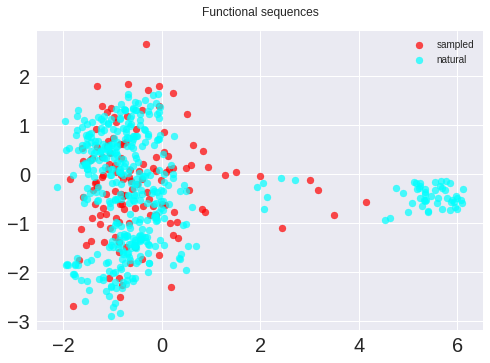

In [ ]:
#Plotting functional sequences

plt.scatter(Z_fun[:, 0], Z_fun[:,1], label='sampled', color = 'red', alpha=0.7)
plt.scatter(X_proj_fun[:, 0], X_proj_fun[:, 1], label='natural', color = 'cyan', alpha=0.7)

plt.legend()
plt.title('Functional sequences', y=1.03)
plt.show()

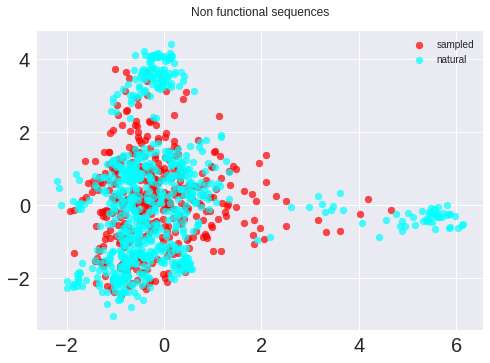

In [ ]:
#Plotting non functional sequences

plt.scatter(Z_nofun[:, 0], Z_nofun[:,1], label='sampled', color = 'red', alpha = 0.7)
plt.scatter(X_proj_nofun[:, 0], X_proj_nofun[:, 1], label='natural', color = 'cyan', alpha=0.7)

plt.legend()
plt.title('Non functional sequences', y=1.03)
plt.show()

## Is our model a good generative model?

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

X_tr, X_te, y_tr, y_te = train_test_split(D, y, test_size=0.2, random_state=1)
print(X_tr.shape)
print(X_te.shape)

(1336, 1920)
(334, 1920)


In [ ]:
model_c=LogisticRegression(max_iter=200)
model_c.fit(X_tr, y_tr)

LogisticRegression(max_iter=200)

[[ 63  46]
 [ 32 193]]


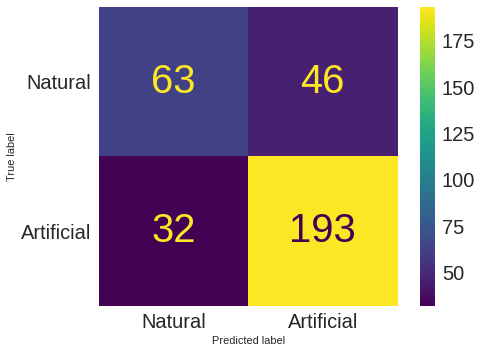

0.7664670658682635

In [ ]:
y_prod = model_c.predict(X_te)
cm = confusion_matrix(y_te, y_prod)

print(cm)

disp=ConfusionMatrixDisplay(cm, display_labels=['Natural','Artificial'])
disp.plot()

plt.grid(False)
plt.show()

model_c.score(X_te, y_te)